# MCMC Tutorial Part1 -- Introduction

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan, and Tony E. Wong

<br>

In this tutorial, we are going to introduce you to the basic concept of Markov Chain Monte Carlo (which we will from now on abbreviate as MCMC). First off, let's import some packages:

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext blackcellmagic

In [2]:
darkblue = "#34495e"

## Linear Model and Parameter Estimation

<!-- In a real world application, we would have some observations of a system. In this tutorial, we will instead fit a two parameter **linear model** to some pseudo observations that we generate. We choose this approach to reduce the complexity of learning and understanding MCMC. It is also useful in understanding the assumptions made according to the structure of the observations. (**This part was adapted from MCMC chapter1**). -->


Let's say we have a linear model that models the amount of ice cream you will consume (where $y$ has units of pints) after going on a bike ride of length $x$ (where $x$ has units of miles). So the true process model, based on the unknown true values of the slope and intercept parameters, which we can call $\alpha^*$ and $\beta^*$, is:

$$y_{true} = \alpha^*x ~ + ~ \beta^*$$

We want to make this more realistic by incorporating some normally-distributed uncertainty, for instance, with mean $0$ and standard deviation $\sigma$.  Call these uncertain measurements $y_{meas}$:

$$y_{meas} = y_{true} ~ + ~ \epsilon = \alpha^*x ~ + ~ \beta^* ~ + ~ \epsilon$$

where $\epsilon \sim N(0, 1)$ is our normally-distributed measurement error. We now want to estimate $\alpha$ and $\beta$. Let us call $\hat{\alpha}$ and $\hat{\beta}$ our estimates of these parameters. They lead to a set of estimates of the response, $\hat{y}$:

$$\hat{y} = \hat{\alpha}x ~ + ~ \hat{\beta}$$

## TO DO!!(parameters estimation problems)

This technique is also known as the parameter estimation problem.

<br>

## Generate Synthetic Data

We can now generate some synthetic data using our linear model, as described above. To do this, we fix the $x$ distance values, at which we will estimate our ice cream intake, covering the range from $0$ to $9.9$ (inclusive), at intervals of $0.1$ miles. In this particular case, let $\alpha^* = 0.5$ and $\beta^* = 8$, which represent the true parameters for our linear model.

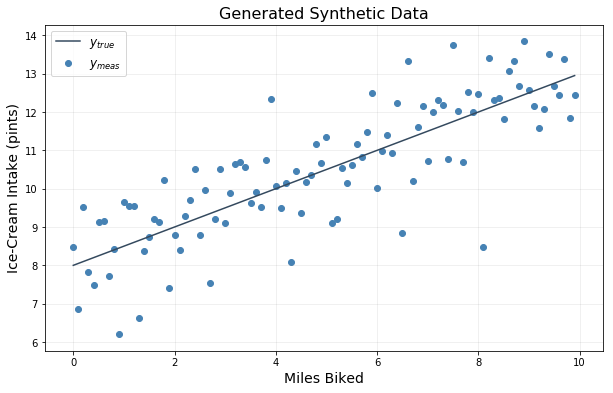

In [3]:
def generate_synthetic_data(astar, bstar, sigma, random_seed=1234, plot=False):
    np.random.seed(random_seed)  # set the seed for sampling.
    # the x values.
    x = np.arange(0, 10, 0.1)
    # the true y values.
    y_true = [astar * x_ + bstar for x_ in x]
    # the synthetic y values.
    y_meas = [stats.norm.rvs(loc=y, scale=sigma) for y in y_true]
    # plot if the user wants to
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
        ax.plot(x, y_true, lw=1.5, color=darkblue, label="$y_{true}$")
        ax.scatter(x, y_meas, color="steelblue", label="$y_{meas}$")
        ax.set_xlabel("Miles Biked", fontsize=14)
        ax.set_ylabel("Ice-Cream Intake (pints)", fontsize=14)
        ax.set_title("Generated Synthetic Data", fontsize=16)
        ax.grid(alpha=0.15, color="gray")
        ax.legend(fontsize=12)
    # return the generated data
    return np.array(x), np.array(y_true), np.array(y_meas)


x, y_true, y_meas = generate_synthetic_data(astar=0.5, bstar=8, sigma=1, plot=True)

## Likelihood Function

The likelihood function describes the plausibility of a parameter value based on observations. Generally, we seek parameter values that maximize the likelihood function. For this example, since we know that the data is normally distributed with mean $0$ and standard deviation $\sigma$, we will use the product of normal distributions for each data point to represent the likelihood function:

$$L(y_{meas} \mid (\alpha, \beta)) = \prod_{i=1}^N f(\hat{y}_i-y_i \mid \mu=0, \sigma)$$

where $f(\hat{y}_i-y_i \mid \mu=0, \sigma)$ is a normal pdf evaluated at $\hat{y}_i - y_i$, with mean $0$ and standard deviation $\sigma$, and $\hat{y} = \alpha x + \beta$ (evaluated at the `x_true` points).

In this analysis, you will work with the **log-probability distributions** for numerical stability reasons. That is, the probabilities involved may be very small, and computers may not be able to distinguish them from 0 in many cases.
<br>

In [4]:
def loglikelihood(theta, y, sigma=1):
    N = len(y)
    alpha, beta = theta[0], theta[1]
    model = alpha * x + beta
    resid = y - model
    log_likelihood = (
        -N / 2 * np.log(2 * np.pi)
        - N * np.log(sigma)
        - 1 / 2 * sum(resid ** 2) / sigma ** 2
    )
    return log_likelihood

## Prior Distribution

The prior distribution is the probability that an event or observation will occur before taking into account new evidence.

For this example, we could use a uniform prior distribution, for $\alpha$ and $\beta$. You may assume that $\alpha$ and $\beta$ are independent, so their prior distribution simplifies to $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$. But similarly to likelihood, we should build up the log-prior, so $log(\pi(\alpha, \beta)) = log(\pi(\alpha)) + log(\pi(\beta))$

<br>

In [5]:
def logprior(theta):
    alpha, beta = theta
    if alpha < 0 or alpha > 100 or beta < 0 or beta > 100:
        return -np.inf
    else:
        return np.log(1 / 100) + np.log(1 / 100)

## Posterior Distribution/Posterior Score

The posterior distribution is defined as being the probability that an event or observation will occur after taking into account all evidence and background information, in light of the uncertainties in both the parameters and the observations. Bayes' theorem defines the posterior probability as proportional to the likelihood of the observations given the parameters times the prior probability of the parameters:

$$\text{posterior distribution} = \pi((\alpha, \beta) \mid y_{meas}) \propto L(y_{meas} \mid (\alpha, \beta)) \times \pi(\alpha, \beta)$$

where $L(y_{meas} \mid (\alpha, \beta))$ is the likelihood function and $\pi(\alpha, \beta)$ is the prior distribution for alpha and beta

The posterior distribution therefore summarizes information about the parameters based on the prior distribution and what the likelihood function says about more "likely" parameter values. The posterior therefore provides a range of parameter values, and says which values are more probable than others. 

In [6]:
def logpost(theta, y, sigma=1):
    log_posterior = loglikelihood(theta, y, sigma) + logprior(theta)
    return log_posterior

## Definition of a Markov Chain

A Markov chain is "a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event." In other words, a random process $X_1, X_2, \ldots$ is a first-order Markov Chain if, for $i = 2, 3, \ldots$, the conditional density function satisfies

$$f(x_i \mid x_{i-1}, \ldots, x_1) = f(x_i \mid x_{i-1})$$

Markov chain models are widely used in statistical modeling, partly because they provide the simplest generalization of independent processes, partly because they are easy to estimate and partly because their proper- ties are well-understood. They can also be generalized to allow dependence on the most recent $k$ observations rather than just the most recent - this is a $k$th-order Markov chain. Because of the dependence of consecutive values in a Markov chain, the distribution of any future value $X_i + m$ is likely to depend on the current value $X_i$. However, for a wide class of Markov chains the dependence diminishes as m becomes large. In other words, a term in the sequence is influenced by the recent history of the series, but much less by its distant past. In this case the chain is said to have a stationary distribution, which is the distribution of $X_n$ as $n \rightarrow \infty$, the point being that the eventual stochastic properties of the process do not depend on the initial condition of the chain.

(**This part was adapted from wiki and Coles 2001**)

## Metropolis-Hastings Algorithm

Introduce as a way to formalize the notion that "Hey, *these* parameters were pretty good, let me propose some more parameters that 'look like' them!" (i.e., use a Markov chain)

The Metropolis-Hastings algorithm is as follows:

![](figs/metropolis_hastings_algo.png)

todo...

### Stationary Distribution

Todo...  review the fact that if you choose your transition probabilities (acceptance probabilities) in THIS special way, then the stationary distribution just happens to be the posterior distribution of your model parameters!

In [7]:
def MCMC_chains(y, step, N=30_000, isPlot=False):
    # randomly generate starting positions.
    alpha_init = np.random.randint(low=0, high=1)
    beta_init = np.random.randint(low=0, high=10)
    theta = [alpha_init, beta_init]
    # set variables.
    lp = logpost(theta, y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0, 0]] * N
    # run the mcmc chain.
    for i in range(N):
        theta_new = list(stats.multivariate_normal.rvs(theta, step))
        lp_new = logpost(theta_new, y)
        lq = lp_new - lp
        lr = np.log(np.random.uniform(0, 1))
        if lr < lq:
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    mcmc_chains = np.array(mcmc_chains)
    # print the acceptance ratio.
    ar = (accepts / N) * 100
    print(f"Acceptance Rate ≈ {ar:.4f}%")
    # plot!
    if isPlot:
        _, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 4))
        ax[0].plot(mcmc_chains[:, 0], linewidth=0.25, color=darkblue)
        ax[0].set_title("History Plots", fontsize=20)
        ax[0].set_ylabel(r"$\alpha$", fontsize=20)
        ax[1].plot(mcmc_chains[:, 1], linewidth=0.25, color="steelblue")
        ax[1].set_ylabel(r"$\beta$", fontsize=20)
    # return the mcmc chain.
    return mcmc_chains

Acceptance Rate ≈ 62.2633%


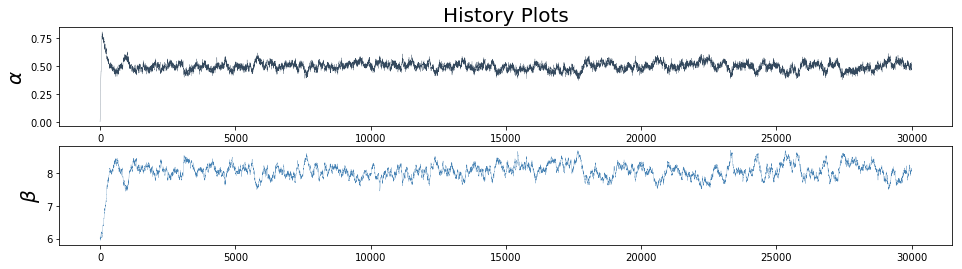

In [8]:
mcmc_chains = MCMC_chains(y_meas, step=[.0005, .001], isPlot=True)

Acceptance Rate ≈ 1.0400%


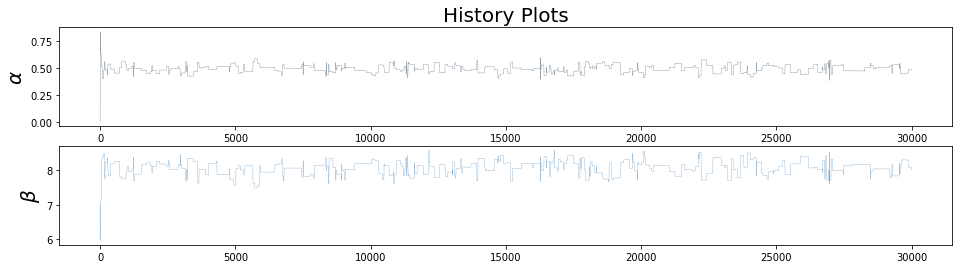

In [9]:
mcmc_chains = MCMC_chains(y_meas, step=[.5, .9], isPlot=True)

Acceptance Rate ≈ 26.7367%


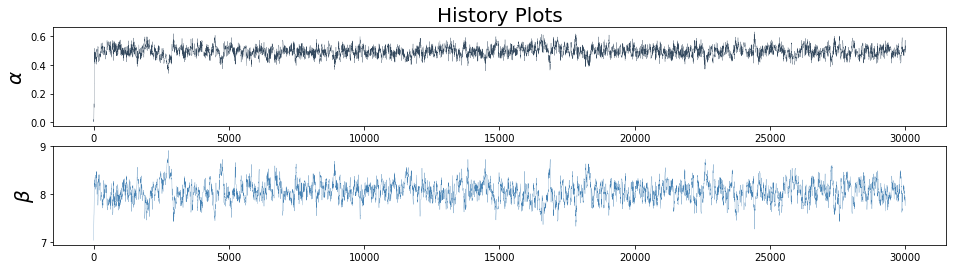

In [10]:
mcmc_chains = MCMC_chains(y_meas, step=[0.005, 0.01], isPlot=True)

## Convergence/Stationarity Diagnostics

We are going to use a diagnostic called the Gelmand-Rubin diagnostic to determine whether or not our chains have completely burnt-in. This diagnostic compares variances between chains. If the diagnostic value is below a certain threshold, then by simply looking at an estimate, we can no longer determine which chain or where in the chain we are in.
</n>

The algorithm for the Gelman-Rubin Diagnostic is as follows:

![](figs/gelman_rubin_diag.png)

<!-- 1. Run m>= 2 chains of length 2n from different initial values -->

<!-- <br> -->

<!-- 2. Discard the first n draws in each chain -->

<!-- <br> -->

<!-- 3. Calculate the within-chain and between-chain variance -->

<!-- $$ Between-chain \ variance = B =  \dfrac{n}{m-1}\sum\limits_{i=1}^m (\overline{\theta_i}-\overline{\overline{\theta}})^2 $$ -->
<!-- $$ \overline{\overline{\theta}} =  \dfrac{1}{m}\sum\limits_{i=1}^m \overline{\theta_i} $$ -->

<!-- $$ Within-chain \ variance = W = \dfrac{1}{m}\sum\limits_{i=1}^m s_{i}^{2}$$ -->

<!-- 4. Calculate the potential scale reduction factor. -->
The basic equation for the diagnostic is as follows -
$$
R = \frac{\hat{V}}{\sigma^2}.\frac{df}{df-2}
$$
For the purposes of our tutorial, we will ignore the degrees of freedom since there are only 2 parameters to estimate and it is a complex operation to calculate the degrees of freedom. So our diagnostic will be calculated as follows -
$$
R = \frac{\hat{V}}{\sigma^2}
$$
The squared scale $\hat{V}$ is given by
$$
\hat{V} = \hat{\sigma}^2 + \frac{B}{mn}
$$
and
$$
\hat{\sigma}^2 = \frac{n-1}{n}W + \frac{1}{n}B
$$
The variables above can be caluclated from the below equations
$$
\begin{equation}
m - \text{number of sequences} \\
B = \frac{n}{(m - 1)}.\Sigma(\mu_i - \bar{\mu})^2 \\
\text{where $\mu_i$ is the average of each chain and $\bar{\mu}$ is the global mean of all estimated variables}
W = \frac{1}{m}.\Sigma{var_i} \\
\text{which is the average of the variances of the chains} \\
n - \text{length of each chain} \\
\end{equation}
$$

In [11]:
mcmc_chains = []
N = 30000
m = 10
for i in range(m):
    mcmc_chains.append(MCMC_chains(y=y_meas, step=[0.005, 0.01], N=N))
mcmc_chains = np.array(mcmc_chains)


def diagnsotic(mcmc_chains):
    m = len(mcmc_chains)
    s_j = [np.var(mcmc_chains[i]) for i in range(m)]
    W = 1 / m * np.sum(s_j)
    global_mean = np.mean([np.mean(mcmc_chains[i]) for i in range(m)])
    B = (
        N
        / (m - 1)
        * np.sum([(np.mean(mcmc_chains[i]) - global_mean) ** 2 for i in range(m)])
    )
    Var = (1 - 1 / N) * W + 1 / N * B
    return np.sqrt(Var / W)


R = [(diagnsotic(mcmc_chains[:, 0, :]))]
burn_in = 1
while burn_in < 10000:
    R.append(diagnsotic(mcmc_chains[:, :burn_in, :]))
    burn_in += 100
R.append(diagnsotic(mcmc_chains[:, burn_in:, :]))

Acceptance Rate ≈ 26.6433%
Acceptance Rate ≈ 26.5067%
Acceptance Rate ≈ 27.1233%
Acceptance Rate ≈ 26.3200%
Acceptance Rate ≈ 26.9533%
Acceptance Rate ≈ 26.4700%
Acceptance Rate ≈ 26.5933%
Acceptance Rate ≈ 27.4100%
Acceptance Rate ≈ 27.2000%
Acceptance Rate ≈ 26.7733%


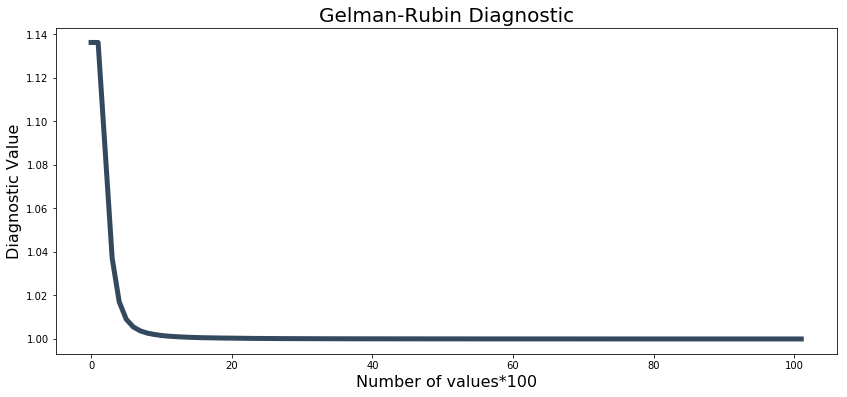

In [12]:
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(R, color=darkblue, lw=5);
ax.set_title("Gelman-Rubin Diagnostic", fontsize=20);
ax.set_xlabel("Number of values*100", fontsize=16);
ax.set_ylabel("Diagnostic Value", fontsize=16);

## Thinning



Now that we have determined whether or not our chains have burnt-in and where each chain has burnt in, now we can thin down our values to estimate our parameters. We can do this by calculating something known as the ```auto-correlation``` value which tells how depedent values are. We want our correlation to be low which tells us that the values are relatively independent. By taking different intervals of values and calculating the correlation, we want to minimize this gap for independent values which is our ```lag```. The correlation has to be calculated for each parameter in every chain, so if we have more parameters, it will start to become compututationally expensive, but the amount of time it will save compared to just using all the values across our chains will be significant. We also want (relatively) independent values for any estimation.

In [13]:
def ACF(X, end=200, interval=1, plot=False):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[: N - a])[0][1])
    if plot:
        _, ax = plt.subplots(figsize=(8, 6))
        ax.stem(x_range, acf)
        ax.set_xlabel("Lag", fontsize=13)
        ax.set_ylabel("ACF", fontsize=13)
    return acf

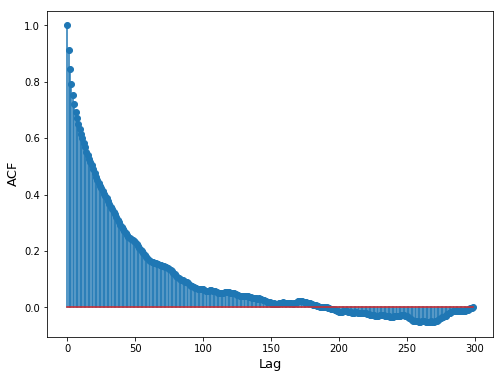

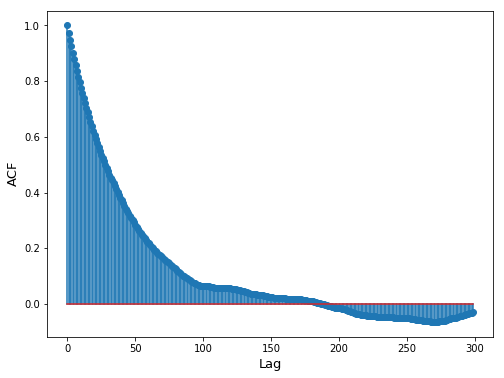

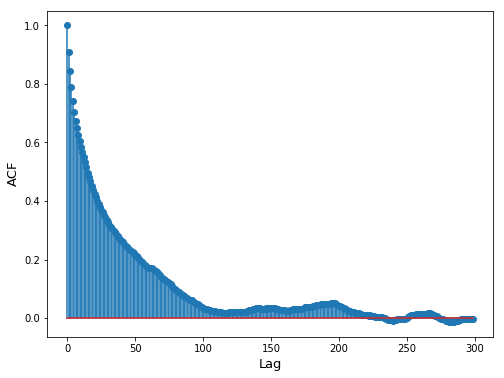

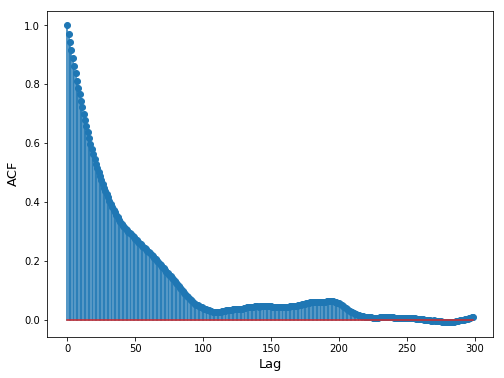

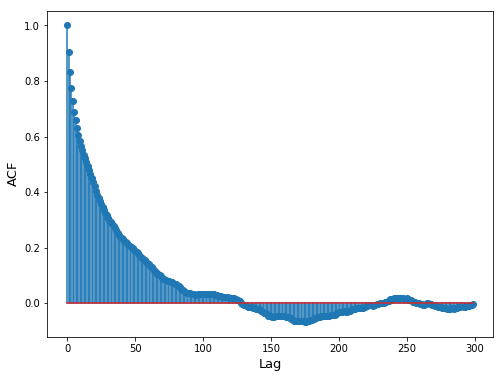

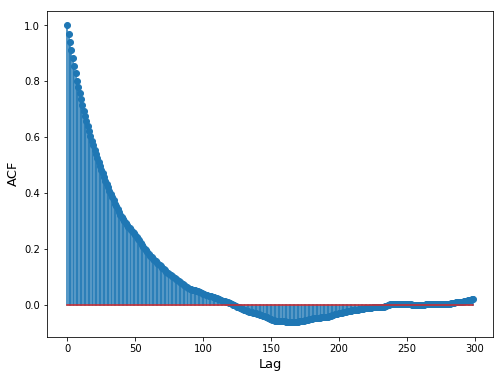

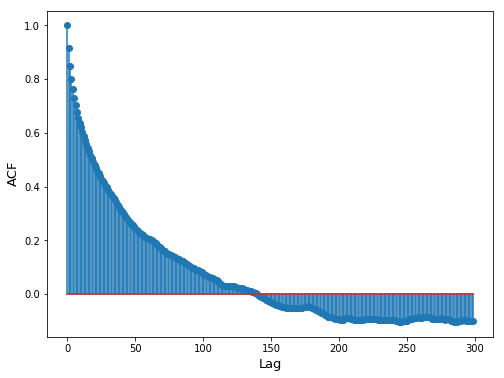

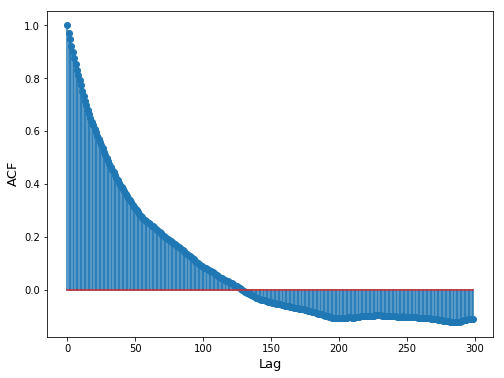

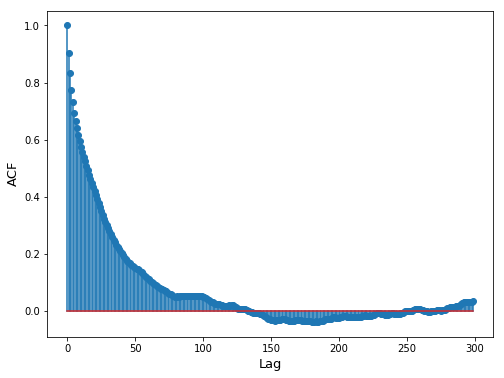

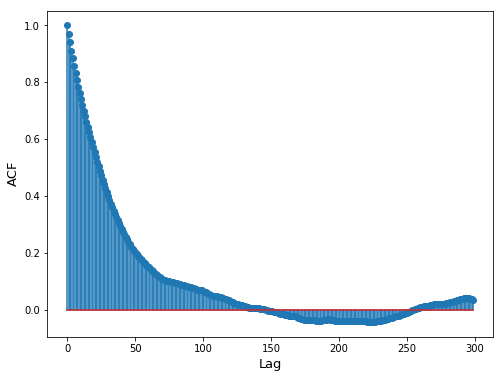

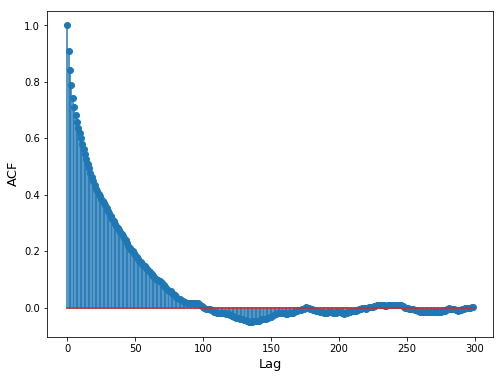

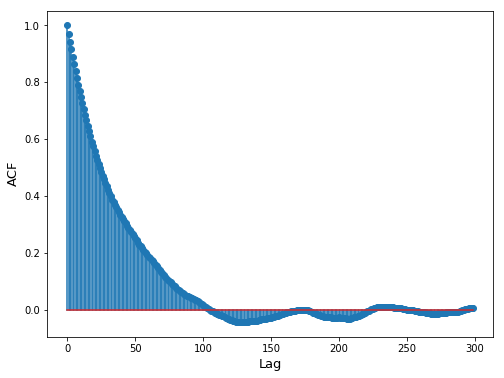

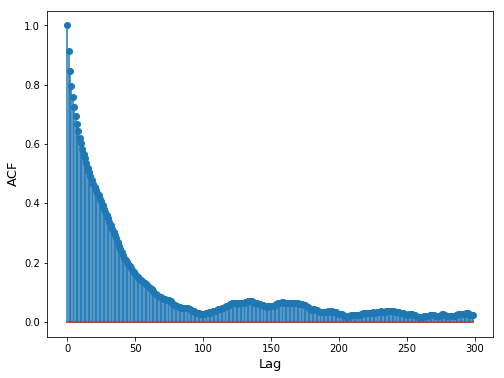

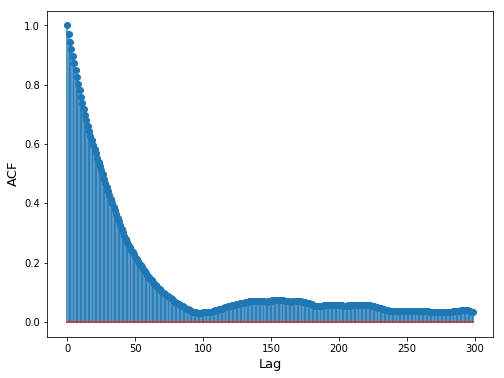

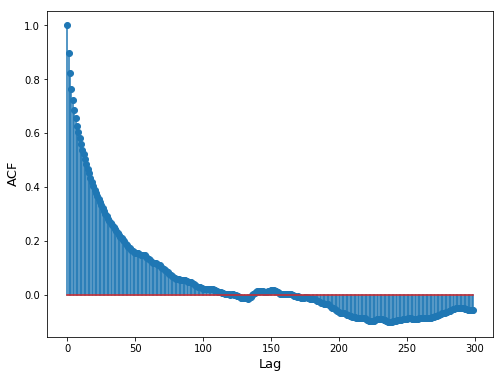

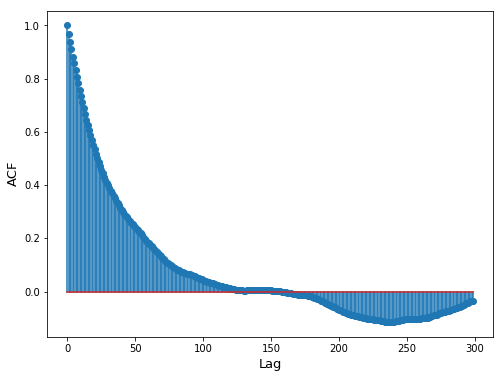

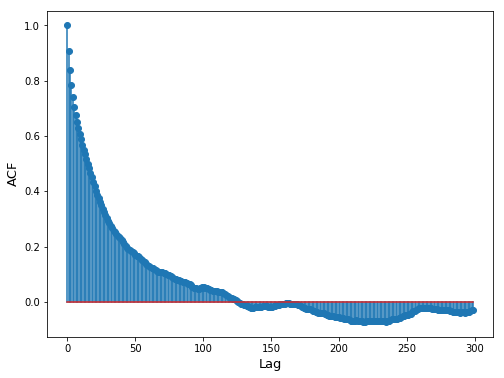

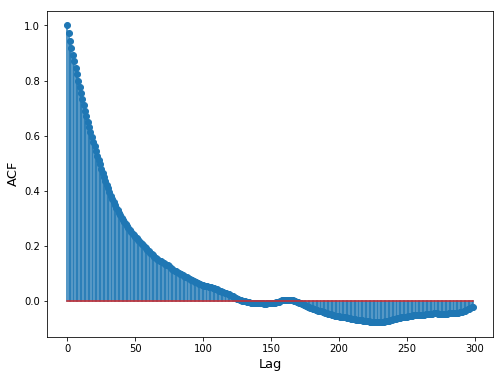

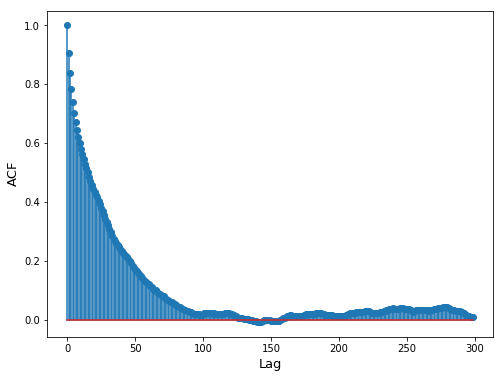

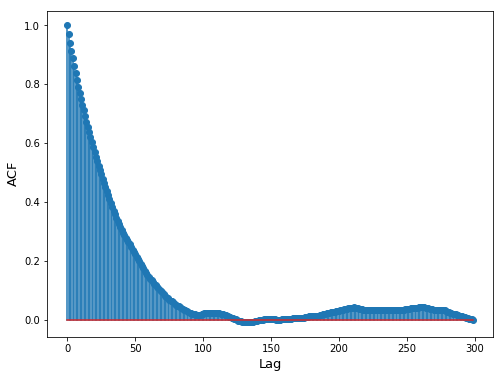

In [14]:
burnin = 10000
acf_alpha = []
acf_beta = []

for i in range(len(mcmc_chains)):
    acf_alpha.append(ACF(mcmc_chains[i, :, 0][burnin:], end=300, plot=True))
    acf_beta.append(ACF(mcmc_chains[i, :, 1][burnin:], end=300, plot=True))

For each chain we have a different ```lag``` value and in each chain, we have different values. We will select the largest of all these values which will ensure some level of certainty  that these values will be relatively independent when selected at these lag intervals. 

## Adaptive Metropolis Algorithm

A proper choice of a proposal distribution for MCMC methods, for example, the Metropolis-Hastings algorithm, is known to be a crucial factor for the convergence of the algorithm. In their paper, Haario etal introduce an adaptive Metropolis (AM) algorithm, where the Gaussian proposal distribution is updated during the process using all of the information accumulated so far. Due to the adaptive nature of the process, the AM algorithm is non-Markovian, but they establish that it has the correct ergodic properties.

We assume that our target distribution is supported on the subset $S \subset \mathcal{R}^d$, and that it has the (unscaled) density $\pi(x)$ with respect to the Lebesgue measure on $S$. With a slight abuse of notation, we shall also denote the target distribution $\pi$. We now explain how the AM algorithm works. Remember that the basic idea is to update the proposal distribution by using the knowledge we have so far acquired about the target distribution. Otherwise the definition of the algorithm is identical to the usual Metropolis process. Suppose, therefore, that at time $t - 1$ we have the sampled states $X_0, X_1, \ldots, X_{t - 1}$, where $X_0$ is the initial state. Then a candidate point $Y$ is sampled from the (asymptotically symmetric) proposal distribution $q_t(. \mid X_0, \ldots, X_{t - 1})$, which now depend on the whole history $(X_0, X_1, \ldots, X_{t - 1})$. The candidate point $Y$ is accepted with probability

$$
\alpha\left(X_{t - 1}, Y\right) = \text{min}\left(1, \frac{\pi(Y)}{\pi(X_{t - 1})}\right)
$$

(**This part was adapted from Haario etal 2001**)

In [15]:
def MCMC_chains(y, step, N=30_000, isPlot=False):
    # randomly generate starting positions.
    alpha_init = np.random.randint(low=0, high=1)
    beta_init = np.random.randint(low=0, high=10)
    theta = [alpha_init, beta_init]
    # set variables.
    lp = logpost(theta, y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0, 0]] * N
    # run the mcmc chain.
    for i in range(N):
        theta_new = list(stats.multivariate_normal.rvs(theta, step))
        lp_new = logpost(theta_new, y)
        lq = lp_new - lp
        lr = np.log(np.random.uniform(0, 1))
        if lr < lq:
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    mcmc_chains = np.array(mcmc_chains)
    # print the acceptance ratio.
    ar = (accepts / N) * 100
    print(f"Acceptance Rate ≈ {ar:.4f}%")
    # plot!
    if isPlot:
        _, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 4))
        ax[0].plot(mcmc_chains[:, 0], linewidth=0.25, color=darkblue)
        ax[0].set_title("History Plots", fontsize=20)
        ax[0].set_ylabel(r"$\alpha$", fontsize=20)
        ax[1].plot(mcmc_chains[:, 1], linewidth=0.25, color="steelblue")
        ax[1].set_ylabel(r"$\beta$", fontsize=20)
    # return the mcmc chain.
    return mcmc_chains

In [16]:
# set up some parameters for adaptive metropolis algorithm

eps = 0.0001

d = 2

I_d = np.identity(d)

S_d = (2.4) ** 2 / 2

In [17]:
# update the covariance matrix by using this function


def update_cov(X, d=2, s_d=S_d, eps=0.0001, i_d=I_d):
    cov = np.cov(X)
    return s_d * cov + i_d * eps * s_d

In [18]:
class AdaptiveMCMC(
    ProblemMCMC
):  # This is the class to set the specific problem we want to solve by using Metropolis-Hastings algorithm
    def random_move(
        self, t, X
    ):  # This is the function to pick a random move by drawing from a multivariate normal distribution
        if t <= self.t0:
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data, self.sigma)

NameError: name 'ProblemMCMC' is not defined

In [ ]:
def Adaptive_mcmc(problem, n_iter):

    # want to keep growing these lists to track the parameter estimates
    alpha = [problem.current.state[0]]
    beta = [problem.current.state[1]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0

    # bar = pyprind.ProgBar(n_iter, title='\nRunning adaptive algorithm on '+sequence_title, bar_char='#')
    with Pool(8) as p:
        for t in range(n_iter - 1):
            S += 1
            nextMove, nextValue = problem.random_move(t, [alpha, beta])
            delta_obj = np.exp(nextValue - lpost[-1])
            if delta_obj > 1:
                # the proposed move is an improvement, so accept w.p. 1
                n_accept += 1
                alpha.append(nextMove[0])
                beta.append(nextMove[1])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                # the proposed move is worse; accept with probability exp[delta_obj/T]
                p_accept = delta_obj
                accept = np.random.choice([True, False], p=[p_accept, 1 - p_accept])
                if accept:
                    n_accept += 1
                    alpha.append(nextMove[0])
                    beta.append(nextMove[1])
                    lpost.append(nextValue)
                    problem.current.state = nextMove
                    problem.current.value = nextValue
                else:
                    alpha.append(alpha[-1])
                    beta.append(beta[-1])
                    lpost.append(lpost[-1])

            # bar.update()

    return (alpha, beta, lpost, n_accept / S)

In [ ]:
chains2, ar2 = sequences_generator(
    mcmc=Adaptive_mcmc,
    problem=AdaptiveMCMC,
    sigma=1,
    data=data,
    m=4,
    n_iter=30000,
    logpost=logpost,
    t0=2000,
    stepsize=[0.005, 0.01],
)

In [ ]:
plot_sequences(chains2)

In [ ]:
alpha_raw2 = []
beta_raw2 = []

for i in range(len(chains2)):
    alpha_raw2.append(chains2[i]["alpha"])
    beta_raw2.append(chains2[i]["beta"])

GR_alpha2 = GR_diag(alpha_raw2, interval=500)
GR_beta2 = GR_diag(beta_raw2, interval=500)

In [ ]:
burnin2 = 10000

acf_alpha2 = []
acf_beta2 = []

for i in range(len(chains2)):
    acf_alpha2.append(ACF(chains2[i]["alpha"][burnin2:], end=200))
    acf_beta2.append(ACF(chains2[i]["beta"][burnin2:], end=200))